In [1]:
import numpy as np             
import sounddevice as sd        #importamos sounddevice paquete para la reproduccion y grabacion de audio 
from scipy.io import wavfile    #modulo para lecto-escritura de archivos .wav
import matplotlib.pyplot as plt
import IPython

In [2]:
from acousticfield.generate import sweep, puretone, whitenoise, pinknoise
from acousticfield.io import play_rec
from acousticfield.process import ir_extract, fadeinout

In [ ]:
sd.query_devices()

In [3]:
sd.default.device = [2,4]

In [ ]:
sweep1 = sweep(T=10.0,fs=48000,f1=30,f2=22000,filename='sweep10s_30_22k')

In [25]:
rec_1 = play_rec('sweep10s_30_22k','rec_L1D1M3') 

listo


In [26]:
ri_1 = ir_extract('rec_L1D1M3','sweep10s_30_22k','ri_1')

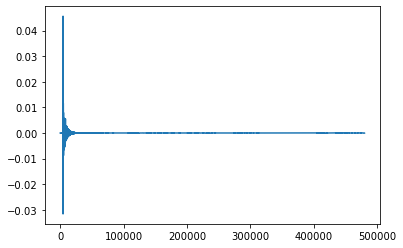

In [27]:
plt.plot(ri_1)

In [16]:
s = whitenoise(2,600)
s = fadeinout(s,0.02)
IPython.display.Audio(s.T,rate=48000)

In [17]:
def fadeio(data, fadein=0.05, fadeout=None, fs=48000):
    if fadein is not None:
        nin = int(2.0*fadein*fs)
        a = (1.0-np.cos(np.linspace(0,np.pi,nin)))/2.0 
        if data.ndim == 2:
            for n in range(data.shape[1]):
                data[:nin,n]  *= a
        else:
            data[:nin] *= a
    if fadeout is not None:
        nout = int(2.0*fadeout*fs)
        a = (1.0+np.cos(np.linspace(0,np.pi,nout)))/2.0 
        if data.ndim == 2:
            for n in range(data.shape[1]):
                data[-nout:,n]  *= a
        else:
            data[-nout:] *= a        

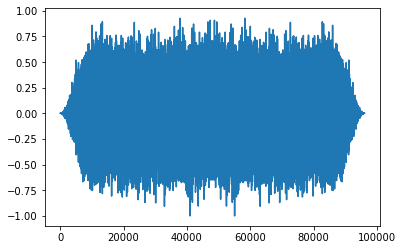

In [22]:
s = whitenoise(2,600)
fadeio(s,0.1,0.1)
plt.plot(s)

In [65]:
def find_dir(data, pw=1.0, fs=48000):
    nw = int(np.floor(pw*fs/1000))
    pmax = np.max(np.abs(data))
    n0 = np.argmax(np.abs(data)>pmax/np.sqrt(10))
    n0=max(n0,nw+1) 
    npk = np.argmax(np.abs(data[n0-nw:n0+nw]))
    nc = n0+npk-nw-2
    n1 = np.maximum(1,int(nc-1.0*nw))
    n2 = int(nc+1.5*nw)
    return [n1,n2]

In [66]:
ndir = find_dir(ri_1,pw=0.5)

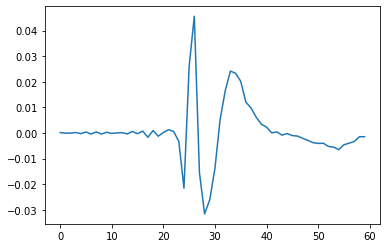

In [67]:
plt.plot(ri_1[ndir[0]:ndir[1]])

In [54]:
np.maximum(1,int(n1 - 1.5*nw))

4470

In [52]:
n1 - 1.5*nw

4470.0